# 2D Gaussian simulation

Originally written as an alternative to the von Mises - Fisher distribution for simulating the effects of propagation.

In [2]:
%matplotlib inline
import sys
sys.path.append('../')
from matplotlib import pyplot as plt
import numpy as np
from fancy import *

In [3]:
# read in relevant data
source_file = 'data/agn_catalog.dat'

# define a Data() instance to handle all data
data = Data()

# add the AGN data
data.add_source(source_file, 'AGN')

In [4]:
# set source parameters
F_T = 500 # total flux
f = 1 # associated fraction
F_A = f * F_T # source flux

In [5]:
# use this model to generate simulated data from the given AGN sources
# distances to AGN
D = data.source['AGN'].distance
# number of AGN
N_A = len(D) 

# function to calculate the weights
def get_weights(D):
    normalisation = 0
    for D_j in D:
        normalisation += (1 / D_j**2)  
    
    w = []
    for D_k in D:
        w.append( (1 / D_k**2) / normalisation)
    w = np.asarray(w)
    return w

# how many events to simulate for each source?
w = get_weights(D)
F = []
for w_k in w:
    F.append(int(round(w_k * F_T)))
print ('Total flux:', sum(F))

Total flux: 497


In [6]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# first try with a 2D gaussian instead of the vMF
# work directly with the galactic coordinates
# standard deviation defintiion
std = 20 # deg

varpi = data.source['AGN'].coord

# funciton to handle wrapping for lats and lons
def wrap(input, limit):
    if limit == 90:
        if input > limit:
            output = input - (2 * limit)
        elif input < -limit:
            output = input + (2 * limit) 
        else: output = input
    elif limit == 360:
        if input > limit:
            output = input - limit
        elif input < 0:
            output = limit + input
        else:
            output = input
    return output
    
omega = []
for i in range(N_A):
    N = F[i]
    mu_lon = varpi.galactic.l.deg[i]
    mu_lat = varpi.galactic.b.deg[i]
    sample_lon = np.random.normal(mu_lon, std, N)
    for j in range(len(sample_lon)):
        sample_lon[j] = wrap(sample_lon[j], 360)
    sample_lat = np.random.normal(mu_lat, std, N)
    for j in range(len(sample_lat)):
        sample_lat[j] = wrap(sample_lat[j], 90)
    sample_coord = SkyCoord(l = sample_lon * u.deg, b = sample_lat * u.deg,
                           frame = 'galactic')
    omega.append(sample_coord)


/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


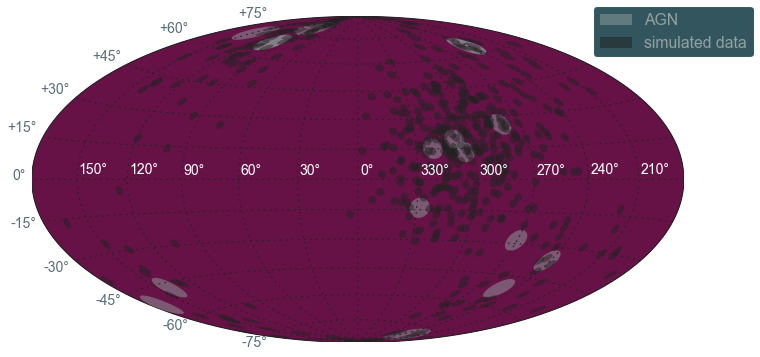

In [7]:
# plot the results on a skymap
fig, skymap = data.show()
label = True
for o in omega:
    for lon, lat in np.nditer([o.galactic.l.deg, o.galactic.b.deg]):
        if label:
            skymap.tissot(lon, lat, 2, npts = 30, facecolor = 'k', alpha = 0.5, 
                          label = 'simulated data')
            label = False
        else:
            skymap.tissot(lon, lat, 2, npts = 30, facecolor = 'k', alpha = 0.5)

plt.gca()
plt.legend(bbox_to_anchor=(0.85, 0.85))